# Задача 3

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [71]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import hashlib
from scipy import stats
import numpy as np
from tqdm.auto import tqdm
#import swifter

In [72]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (3,0)
    group by exp_group, user_id
    '''
).df

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [73]:
data = df.groupby('exp_group',as_index =False).agg({'user_id':'count','likes':'sum','views':'sum'}) 
data['ctr']=data['likes']/data['views']
data

,exp_group,user_id,likes,views,ctr
0,0,9999,139862,671651,0.208236
1,3,10049,150359,670360,0.224296


In [74]:
ctr_control_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
ctr_control_0

0.20823612262916305

In [75]:
df['linearized_likes'] = df.likes - (df.views * ctr_control_0)

In [76]:
df.head(2)

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,9,30,0.300000,2.752916
1,3,123580,13,48,0.270833,3.004666


In [77]:
pvalue_ll = stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var=False)

In [78]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr)/(user_views + alpha)
    return smothed_ctr

In [79]:
global_ctr_1 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr_2 = df[df.exp_group == 3].likes.sum()/df[df.exp_group == 3].views.sum()
group1 = df[df.exp_group == 0].copy()
group2 = df[df.exp_group == 3].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_1,5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2,5), axis=1)

In [80]:
pvalue_CTR = stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)
pvalue_CTR

Ttest_indResult(statistic=-16.340715063416575, pvalue=1.231422928821838e-59)

In [82]:
print("p-value ttest ctr: ", pvalue_CTR[1])
print("p-value ttest linearized_likes: ", pvalue_ll[1])
print("Раздичие p-value между ttest linearized_likes и ttest ctr: ", pvalue_CTR[1]-pvalue_ll[1])

p-value ttest ctr:  1.231422928821838e-59
p-value ttest linearized_likes:  5.4914249479690016e-52
Раздичие p-value между ttest linearized_likes и ttest ctr:  -5.491424824826709e-52


#### Нет, p-value стал больше, но незначильно, т.е. новый способ не сделала хуже) Оба теста показывают,что данные в группах статистически различные. В группе 3 ctr выше, можно расскатывать новую фичу на всех.

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

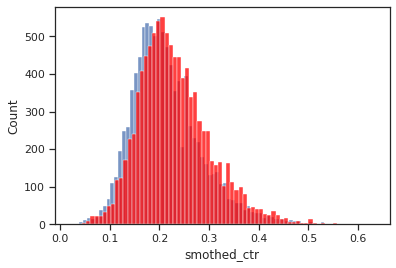

In [83]:
sns.histplot(group1['smothed_ctr'])
sns.histplot(group2['smothed_ctr'], color = 'red')

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

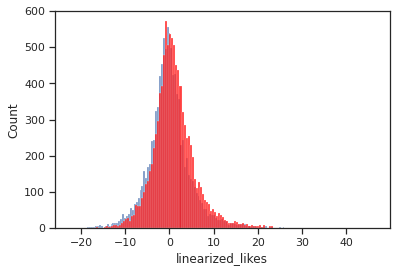

In [84]:
sns.histplot(df[df.exp_group == 0]['linearized_likes'])
sns.histplot(df[df.exp_group == 3]['linearized_likes'], color = 'red')

In [85]:
df_1 = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    group by exp_group, user_id
    '''
).df

In [86]:
data_1 = df_1.groupby('exp_group',as_index =False).agg({'user_id':'count','likes':'sum','views':'sum'}) 
data_1['ctr']=data_1['likes']/data_1['views']
data_1

,exp_group,user_id,likes,views,ctr
0,1,10079,139011,668236,0.208027
1,2,9952,130385,658310,0.198060


In [87]:
ctr_control_1 = df_1[df_1.exp_group == 1].likes.sum()/df_1[df_1.exp_group == 1].views.sum()
ctr_control_1

0.20802680490126244

In [88]:
df_1['linearized_likes'] = df_1.likes - (df_1.views * ctr_control_1)

In [89]:
pvalue_ll_1 = stats.ttest_ind(df_1[df_1.exp_group == 1].linearized_likes,
                df_1[df_1.exp_group == 2].linearized_likes,
                equal_var=False)

In [90]:
global_ctr_1 = df_1[df_1.exp_group == 1].likes.sum()/df_1[df_1.exp_group == 1].views.sum()
global_ctr_2 = df_1[df_1.exp_group == 2].likes.sum()/df_1[df_1.exp_group == 2].views.sum()
group1 = df_1[df_1.exp_group == 1].copy()
group2 = df_1[df_1.exp_group == 2].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_1,5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2,5), axis=1)

In [91]:
pvalue_CTR_1 = stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)
pvalue_CTR_1

Ttest_indResult(statistic=2.6709984704024947, pvalue=0.007568711039438521)

In [92]:
print("p-value ttest ctr: ", pvalue_CTR_1[1])
print("p-value ttest linearized_likes: ", pvalue_ll_1[1])
print("Раздичие p-value между ttest linearized_likes и ttest ctr: ",pvalue_CTR_1[1] -pvalue_ll_1[1])

p-value ttest ctr:  0.007568711039438521
p-value ttest linearized_likes:  9.439432187037712e-10
Раздичие p-value между ttest linearized_likes и ttest ctr:  0.007568710095495302


#### Да, p-value стал значительно меньше (это видно на глаз). Но и t-test показывал различие в данных. В этом случае мы "бесплатно" увеличили чувствительность метрики. Оба теста показали, что различие в группе статистически значимо. В группе 2 ctr ниже, не стоит торопиться и расскатывать новую фичу.

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

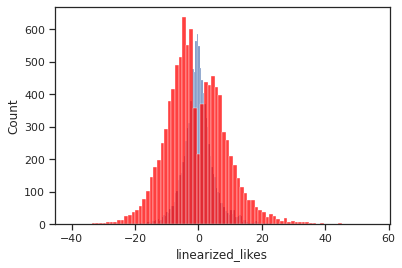

In [18]:
sns.histplot(df_1[df_1.exp_group == 1]['linearized_likes'])
sns.histplot(df_1[df_1.exp_group == 2]['linearized_likes'], color = 'red')

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

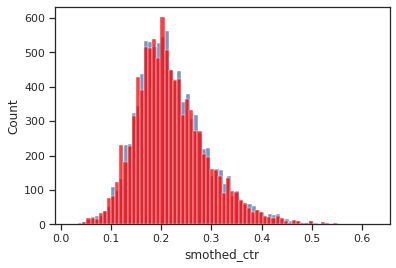

In [93]:
sns.histplot(group1['smothed_ctr'])
sns.histplot(group2['smothed_ctr'], color = 'red')